<a href="https://colab.research.google.com/github/joshlensing/Coding-Dojo-Project-2/blob/main/Project_2_Baseball_Playoff_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseball Playoffs Predictions

I want to use baseball stats from baseball teams from 1962-2012 in order to predict whether teams will make the playoffs or not. I am a very big fan of baseball and have been since I was 8 years old. Baseball data and analytics are becoming a very big component of how professional baseball teams operate. A lot of this dataset comes from the idea of "Moneyball," where Billy Beane, the GM of the Oakland Athletics, found statisitics relating to individual player performance that scouts and other front offices were not focused on at the time. He hoped to use those background statistics and develop a formula for success that didn't require spending a large amount of money to build a roster of players. Instead, he hoped to find players that scored well in these statistical categories that other teams would often overlook and pay them cheaply to play for the Athletics. The hope was to ultimately make the playoffs and compete for a championship.

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/content/baseball.csv')
df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


##Exploring and Cleaning the Data

###Get some information about the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          1232 non-null   object 
 1   League        1232 non-null   object 
 2   Year          1232 non-null   int64  
 3   RS            1232 non-null   int64  
 4   RA            1232 non-null   int64  
 5   W             1232 non-null   int64  
 6   OBP           1232 non-null   float64
 7   SLG           1232 non-null   float64
 8   BA            1232 non-null   float64
 9   Playoffs      1232 non-null   int64  
 10  RankSeason    244 non-null    float64
 11  RankPlayoffs  244 non-null    float64
 12  G             1232 non-null   int64  
 13  OOBP          420 non-null    float64
 14  OSLG          420 non-null    float64
dtypes: float64(7), int64(6), object(2)
memory usage: 144.5+ KB


Based on the dtypes from the information about the data, it appears that all of the columns in the dataset match the data dictionary. There also appear to be quite a few missing data values from a couple of columns. Overall there are 1,232 rows and 15 columns.

In [5]:
df.shape

(1232, 15)

### Check for duplicated rows

In [6]:
df.duplicated().sum()

0

There are 0 duplicated rows. Next I want to look at the missing values more closely and see what I am working with for modeling.

### Checking for missing values

In [7]:
df.isna().sum()

Team              0
League            0
Year              0
RS                0
RA                0
W                 0
OBP               0
SLG               0
BA                0
Playoffs          0
RankSeason      988
RankPlayoffs    988
G                 0
OOBP            812
OSLG            812
dtype: int64

I'll also look at the percentages of the missing value columns to beter understand how much data I'm actually missing.

In [8]:
df.isna().sum()/len(df)*100

Team             0.000000
League           0.000000
Year             0.000000
RS               0.000000
RA               0.000000
W                0.000000
OBP              0.000000
SLG              0.000000
BA               0.000000
Playoffs         0.000000
RankSeason      80.194805
RankPlayoffs    80.194805
G                0.000000
OOBP            65.909091
OSLG            65.909091
dtype: float64

Looking at the data and understanding what each column means to the dataset, I am going to drop 2 of the rows. 'RankSeason' and 'RankPlayoff' are not necessary to predicting whether or not the team is going to make the playoffs. The column gives the seed rank of the team that makes the playoffs. 'RankPlayoff' is exclusive to those teams that make the playoffs, so it would act as a cheating tool for the training and testing sets in modeling. 'RankSeason' seems to do the same thing as 'RankPlayoff', so it will be dropped as well.

The missing data in 'OOBP' and 'OSLG' will not be replaced for data exploration, but it will not be dropped for modeling either. These columns look at opponent on-base and slugging percentage, so they could still be useful in the predictions.

In [9]:
df = df.drop(columns=['RankSeason', 'RankPlayoffs'])
df.columns

Index(['Team', 'League', 'Year', 'RS', 'RA', 'W', 'OBP', 'SLG', 'BA',
       'Playoffs', 'G', 'OOBP', 'OSLG'],
      dtype='object')

###Checking for consistency in the data

I will first check the categorical and numerical values for consistency and potential impossible numerical values.

In [10]:
# checking categorical data
print(df['Team'].value_counts())
print(df['League'].value_counts())

HOU    47
DET    47
NYY    47
NYM    47
MIN    47
LAD    47
SFG    47
PIT    47
PHI    47
STL    47
CLE    47
CIN    47
CHW    47
CHC    47
BOS    47
BAL    47
ATL    43
OAK    41
KCR    40
SDP    40
MIL    39
TEX    37
TOR    33
SEA    33
MON    32
CAL    28
COL    18
FLA    17
ARI    15
LAA    11
TBD    10
WSA    10
WSN     8
ANA     8
KCA     6
TBR     5
MLN     4
MIA     1
SEP     1
Name: Team, dtype: int64
NL    616
AL    616
Name: League, dtype: int64


There are 30 teams in MLB currently, but there appear to be more than that in this dataset. I will double check this now without counting them individually.

In [11]:
df['Team'].nunique()

39

There are teams that have gone by different names over the 50 years of the dataset, so some teams will be represented by different names as the years went on.

___

After checking the categorical data values, now I will check the numerical values and check for any impossible numbers in the dataset.

In [12]:
# checking the numerical values
df.describe(include='number')

,Year,RS,RA,W,OBP,SLG,BA,Playoffs,G,OOBP,OSLG
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,420.000000,420.000000
mean,1988.957792,715.081981,715.081981,80.904221,0.326331,0.397342,0.259273,0.198052,161.918831,0.332264,0.419743
std,14.819625,91.534294,93.079933,11.458139,0.015013,0.033267,0.012907,0.398693,0.624365,0.015295,0.026510
min,1962.000000,463.000000,472.000000,40.000000,0.277000,0.301000,0.214000,0.000000,158.000000,0.294000,0.346000
25%,1976.750000,652.000000,649.750000,73.000000,0.317000,0.375000,0.251000,0.000000,162.000000,0.321000,0.401000
50%,1989.000000,711.000000,709.000000,81.000000,0.326000,0.396000,0.260000,0.000000,162.000000,0.331000,0.419000
75%,2002.000000,775.000000,774.250000,89.000000,0.337000,0.421000,0.268000,0.000000,162.000000,0.343000,0.438000
max,2012.000000,1009.000000,1103.000000,116.000000,0.373000,0.491000,0.294000,1.000000,165.000000,0.384000,0.499000


All of the numerical values look good, so now I will move on to the data exploratory analysis.

## Exploratory Data Analysis

### Univariate Visuals of Target Data and Features

To gain a better understanding of the target and features of my data,  I can visualize each of them to know how the values in each column compare. Histograms are a great way to compare the values in the rows of a dataset and are fairly easy to understand how much of each value exists. To do this, I will create a function that allows me plot the same histogram for each column, then I will loop through the columns in order to create visuals for each one.

In [23]:
def plot_dist(data, x, figsize = (12,6)):

  fig, ax = plt.subplots(figsize = figsize)
  ## Plot histogram
  sns.histplot(data = data, x = x, ax = ax)
  plt.xticks(rotation=45)

  return fig, ax

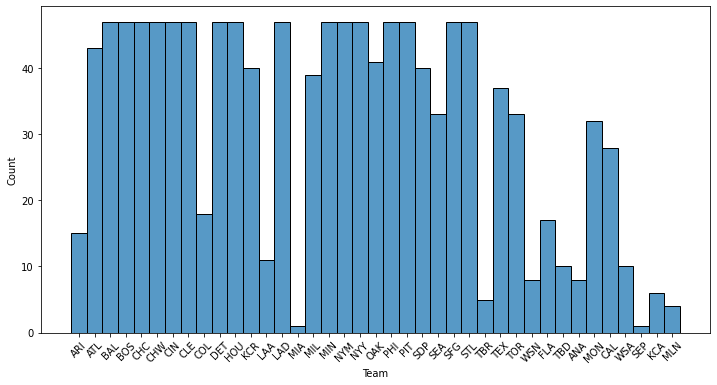

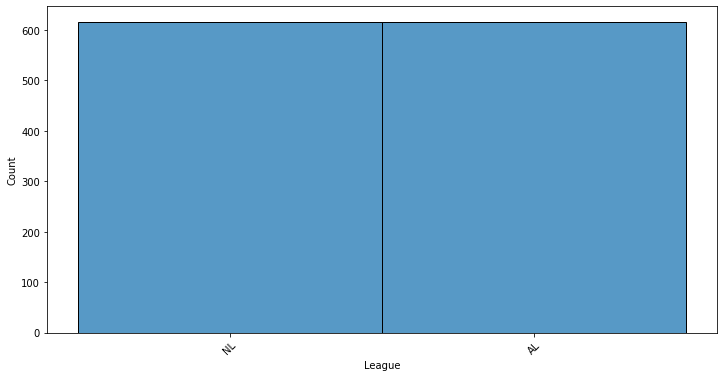

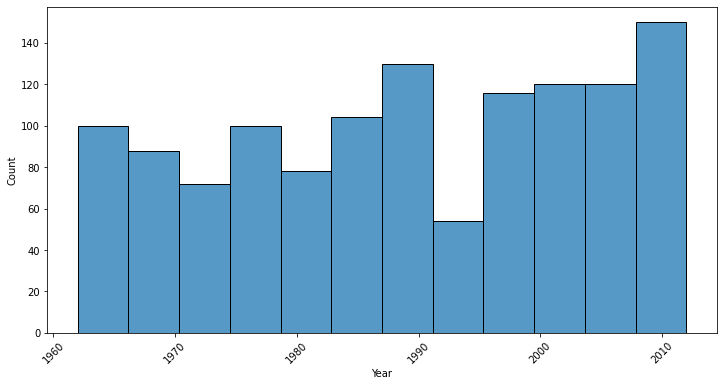

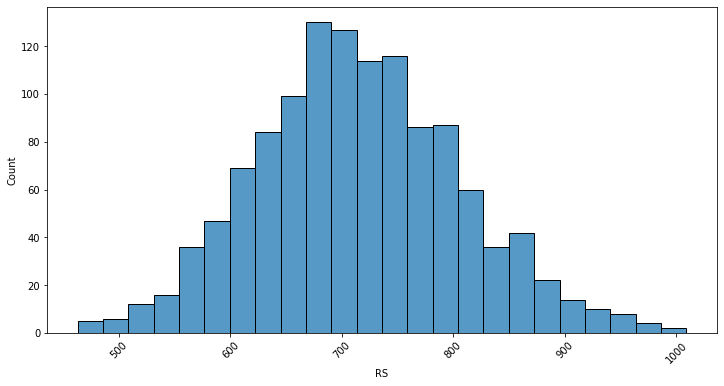

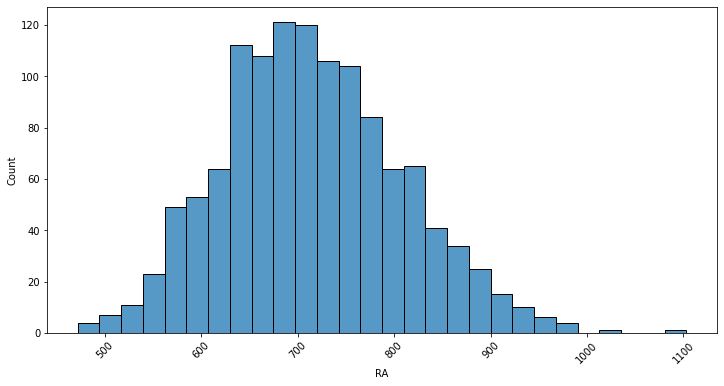

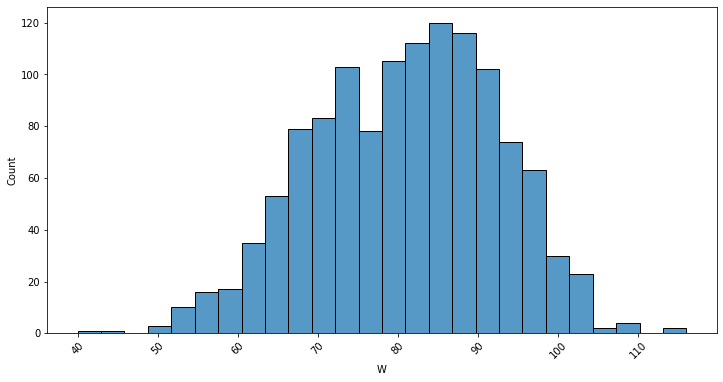

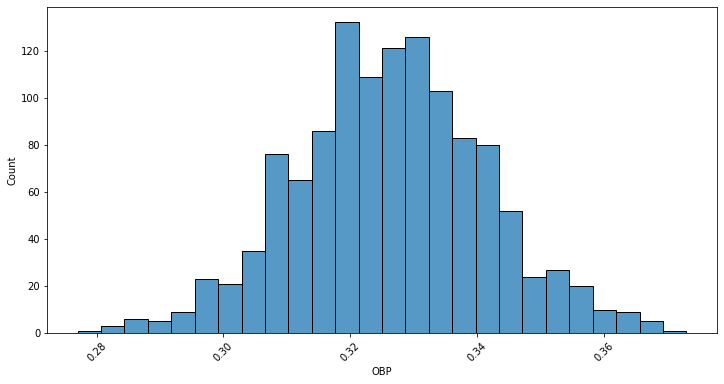

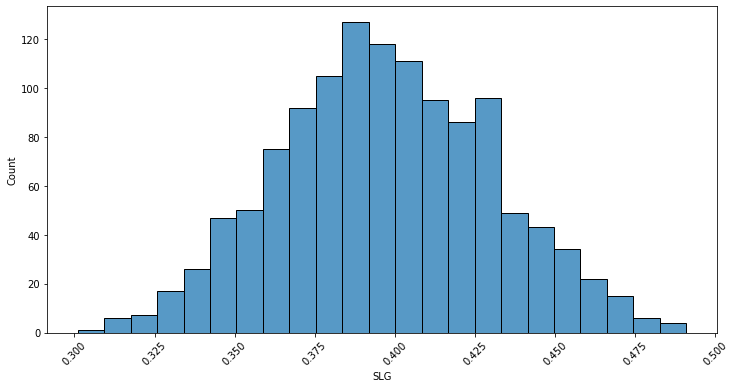

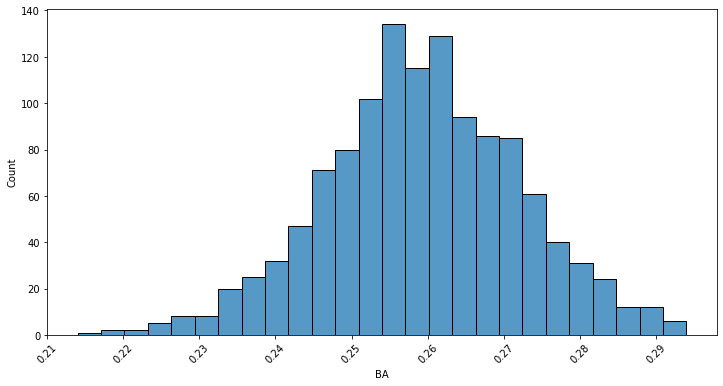

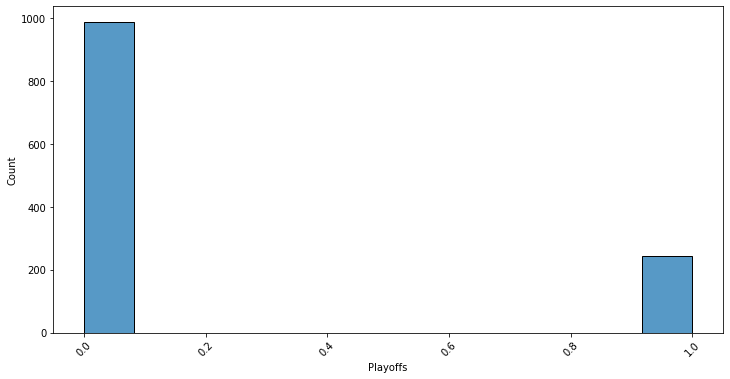

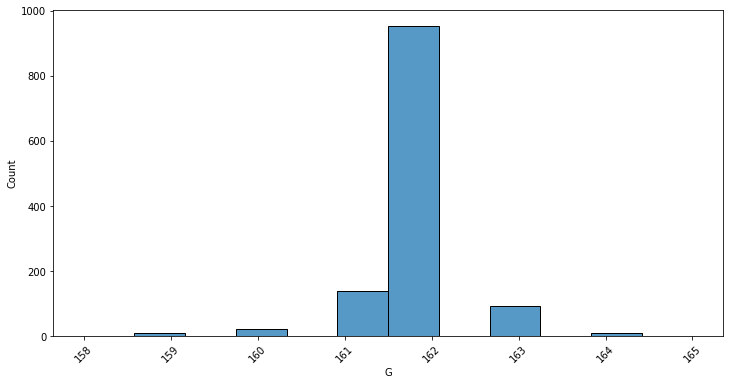

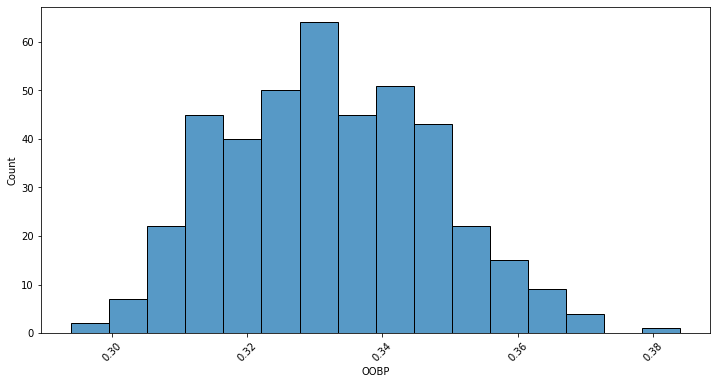

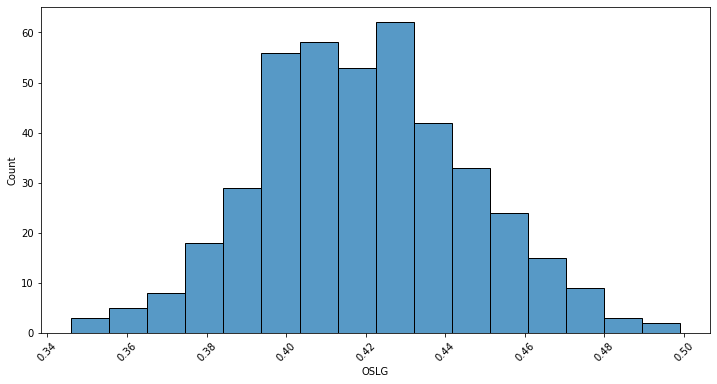

In [24]:
cols = df.columns
for col in cols:
  fig, ax = plot_dist(df, col)

### Visualizing Outliers

The best method to visualizing outliers is through the use of a boxplot. As with the histograms in the previous section, I will create a function for the boxplots and loop through the numeric columns in order to visualize the outliers for each column.

In [32]:
# creating a function for the boxplots
def box_plot(data, x, y, figsize = (10,5)):

  fig, ax = plt.subplots(figsize = figsize)
  ## Plot boxplot
  sns.boxplot(data = data, x = x, y = y, notch=True)

  return fig, ax

In [39]:
dtypes = df.dtypes
box_cols1 = dtypes[dtypes == 'int'].index
box_cols1

Index(['Year', 'RS', 'RA', 'W', 'Playoffs', 'G'], dtype='object')

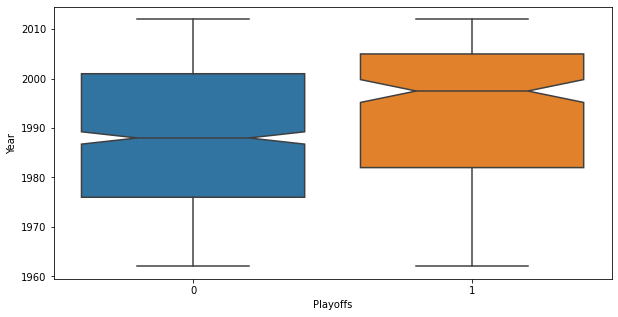

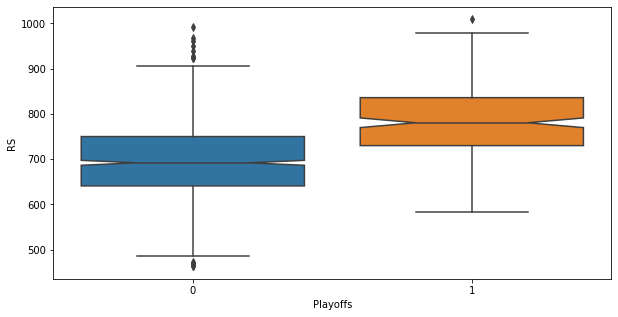

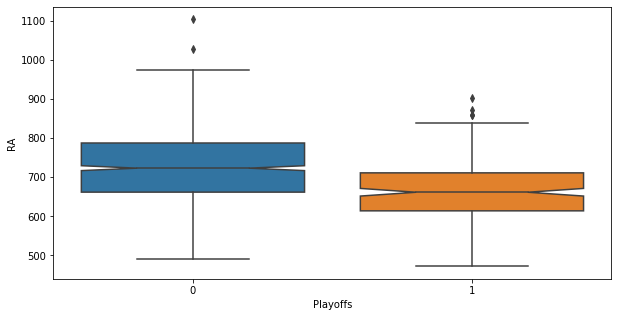

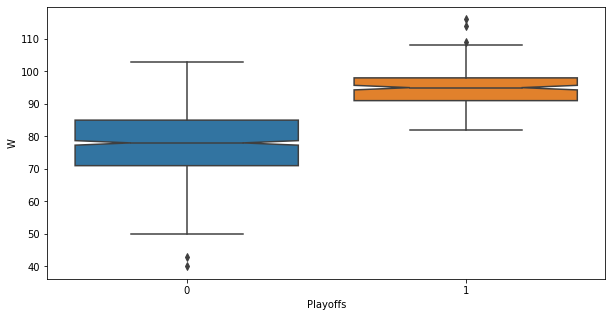

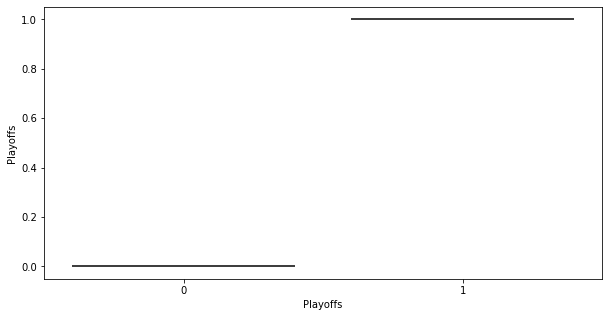

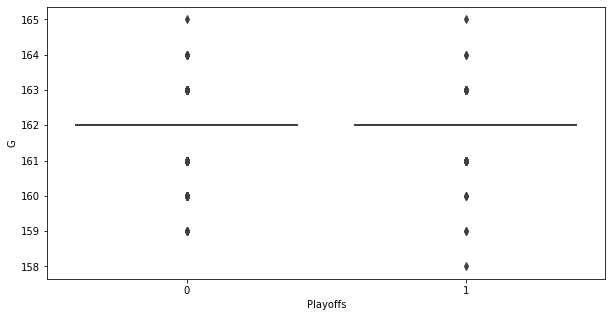

In [42]:
# creating a loop for the integer boxplots
for col in box_cols1:
  box_plot(df, 'Playoffs', col)

In [44]:
# float columns will also need to have boxplots
box_cols2 = dtypes[dtypes == 'float'].index
box_cols2

Index(['OBP', 'SLG', 'BA', 'OOBP', 'OSLG'], dtype='object')

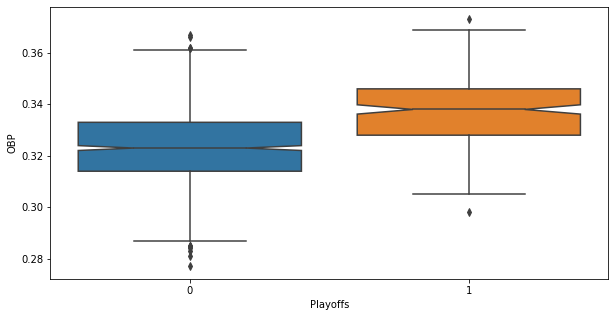

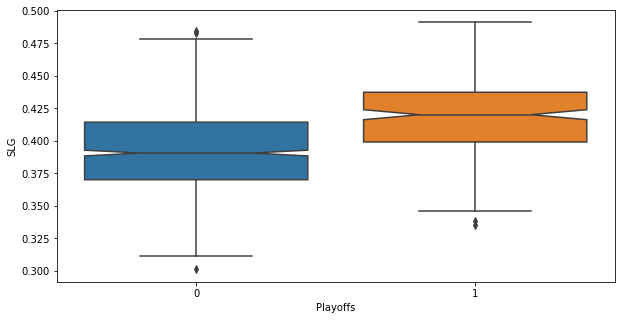

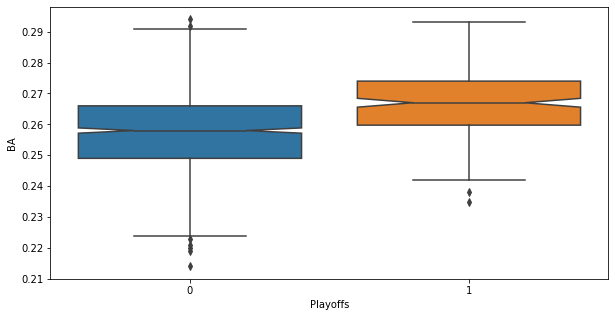

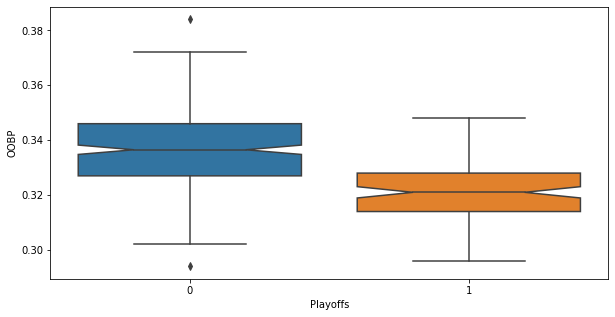

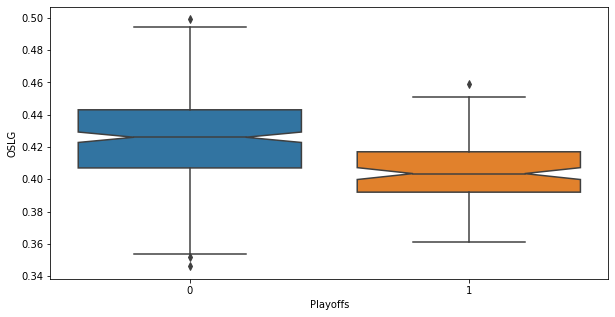

In [43]:
# creating a loop for the boxplots
for col in box_cols2:
  box_plot(df, 'Playoffs', col)

OBP, SLG, BA, OOBP, OSLG all have outliers in the dataset, although there are very few. RS, RA, and W all had outliers as well in the integer columns. G had outliers as well, although that is because most of the seasons had a certain number of games played, while others had played fewer, either due to a work stoppage or a schedule expansion in more recent years.

##Explanatory Data Analysis (started early)

The number of wins dictates which teams make the playoffs and which don't. The number varies from year to year, depending on the performance of teams in certain divisions. One thing that will be helpful to visualize will be to see the most successful teams over the 50 year period from 1962-2012. To do this, I will see the average number of wins per team in the dataset and plot them in a barplot.

In [45]:
avg_wins = df.groupby(['Team'])['W'].mean().sort_values(ascending=False)
avg_wins

Team
TBR    91.600000
NYY    90.255319
LAA    88.000000
LAD    86.489362
MLN    86.000000
BOS    85.893617
STL    85.723404
SFG    84.574468
OAK    84.097561
CIN    84.021277
ATL    83.395349
BAL    83.361702
ANA    83.000000
PHI    82.319149
MIN    81.723404
CHW    81.659574
TOR    81.212121
ARI    80.666667
DET    80.276596
TEX    79.945946
PIT    79.489362
HOU    78.978723
CAL    78.178571
MIL    77.846154
MON    77.656250
CLE    77.489362
FLA    77.470588
CHC    77.425532
NYM    77.382979
KCR    77.325000
COL    76.166667
SDP    75.725000
SEA    75.515152
WSN    73.750000
MIA    69.000000
WSA    67.900000
KCA    66.166667
TBD    64.500000
SEP    64.000000
Name: W, dtype: float64

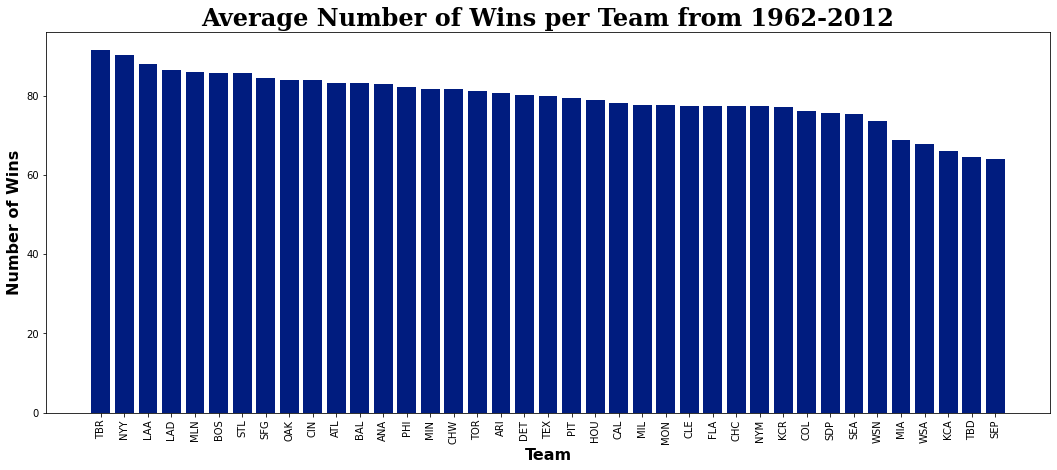

In [46]:
# plotting with a barplot
with plt.style.context('seaborn-dark-palette'): 
  fig, ax = plt.subplots(figsize = (18,7))
  plt.bar(avg_wins.index, avg_wins.values);
  plt.xlabel('Team', fontsize=16, fontweight='bold')
  plt.ylabel('Number of Wins', fontsize=16, fontweight='bold')
  plt.title('Average Number of Wins per Team from 1962-2012', fontsize=24, fontweight='black', fontfamily='serif')
  plt.xticks(rotation = 90);

TBR, or the Tampa Bay Rays, have the highest average number of wins during the 50 year period. This graph is really useful in seeing the teams that have had the highest level of success. The Athletics are in the top 10 of teams in wins, so their formula for success seems to have helped their season to season performance.

Another good measure of team success is seeing how runs allowed ('RA') differs between playoff teams and non playoff teams. Good pitching and defense has been theorized to be a vital component to successful teams, so I can view that with a boxplot between the 2.

Next, I want to see the distribution of wins and OBP and see what plots lead to a playoff spot. I can achieve this by creating a scatterplot and plotting the wins on the x-axis and OBP on the y-axis. This will give me a good idea of how well a higher OBP leads to team wins.

In [ ]:
# filtering the dataset for last 25 years
obp_df = df[df['Year'] > 1987]
obp_df

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,SEA,AL,1988,664,744,68,0.317,0.398,0.257,0,161,NaN,NaN
660,SFG,NL,1988,670,626,83,0.318,0.368,0.248,0,162,NaN,NaN
661,STL,NL,1988,578,633,76,0.309,0.337,0.249,0,162,NaN,NaN
662,TEX,AL,1988,637,735,70,0.320,0.368,0.252,0,161,NaN,NaN


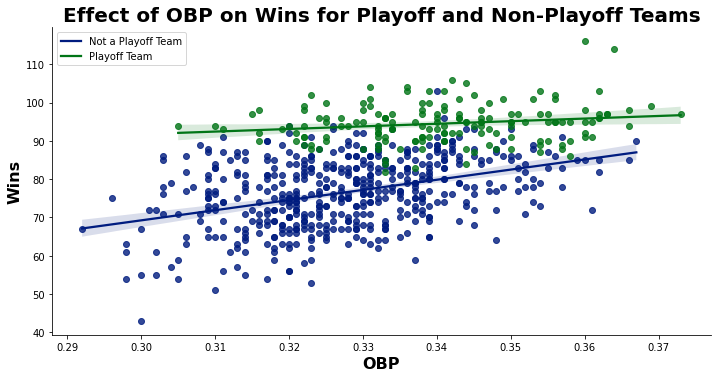

In [ ]:
# creating the plot with Seaborn
with plt.style.context('seaborn-dark-palette'):
  g = sns.lmplot(data=obp_df, x='OBP', y='W', hue='Playoffs', legend=False, aspect=2)
  plt.xlabel('OBP', fontsize=16, fontweight='bold')
  plt.ylabel('Wins', fontsize=16, fontweight='bold')
  plt.title('Effect of OBP on Wins for Playoff and Non-Playoff Teams',
            fontsize=20,
            fontweight='black')
  plt.legend(loc='upper left', labels=['Not a Playoff Team', 'Playoff Team']);

For teams over the last 25 years of the dataset, it looks like the OBP gave teams a slightly better chance of making the playoffs, as the data points for teams that won are shifted farther to the right than the teams that did not make the playoffs.

Source for changing legend labels: https://stackoverflow.com/questions/45201514/how-to-edit-a-seaborn-legend-title-and-labels-for-figure-level-functions